In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from optuna.integration import TFKerasPruningCallback
import tensorflow as tf
import joblib

# Load dataset
train_data = pd.read_csv('Training_dt.csv')
train_data = train_data.drop('Mask No', axis=1)
test_data = pd.read_csv('Testing_dt.csv')
test_data = test_data.drop('Mask No', axis=1)

# Define columns
numerical_cols = ['LEASE_TENOR_INCLUDING_HP', 'CUSTOMER AGE', 'Exp', 'YOM']
categorical_cols = ['PRODUCT_NAME', 'Sub_purpose_code_based_on_risk', 'CRIB_SCORE', 'TOTAL INCOME',
                    'Percentage_of_Total_Installments_to_Total_Current_Balance_slabs',
                    'Percentage_of_Total_Current_Balance_to_Total_Amount_Granted_Limit_slabs',
                    'Percentage_of_Total_Arrears_Amount_to_Total_Amount_Granted_Limit_slabs']
target_col = 'Cluster'

# Encode categorical columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_train = train_data[numerical_cols + categorical_cols]
y_train = train_data[target_col]

X_test = test_data[numerical_cols + categorical_cols]
y_test = test_data[target_col]

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Handle imbalance using advanced methods
def handle_imbalance(X, y):
    imbalance_methods = {
        'SMOTETomek': SMOTETomek(sampling_strategy='auto'),
        'SMOTE': SMOTE(sampling_strategy='auto'),
        'ADASYN': ADASYN(sampling_strategy='auto')
    }

    best_method = None
    best_score = -np.inf
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, method in imbalance_methods.items():
        X_resampled, y_resampled = method.fit_resample(X, y)
        clf = RandomForestClassifier()
        scores = cross_val_score(clf, X_resampled, y_resampled, cv=kf, scoring='roc_auc_ovr')
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_method = method

    return best_method.fit_resample(X, y)

X_train_resampled, y_train_resampled = handle_imbalance(X_train_processed, y_train_encoded)

# Add class weights to handle imbalance directly in the model
class_weights = dict(enumerate(np.bincount(y_train_resampled) / len(y_train_resampled)))

# Define ML algorithms
ml_algorithms = {
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced')
}

# Cross-validation to select the best ML algorithm
best_algorithm = None
best_score = -np.inf
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in ml_algorithms.items():
    try:
        scores = cross_val_score(clf, X_train_resampled, y_train_resampled, 
                                 cv=kf, 
                                 scoring='roc_auc_ovr')
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_algorithm = clf
    except Exception as e:
        print(f"Error with {name}: {e}")

# Check if a valid algorithm was selected
if best_algorithm is None:
    raise ValueError("No valid machine learning algorithm was selected.")

# Fit the best ML algorithm on the entire dataset
best_algorithm.fit(X_train_resampled, y_train_resampled)

# Use the predictions of the best ML algorithm as additional input to the ANN
ml_train_predictions = best_algorithm.predict_proba(X_train_resampled)
ml_test_predictions = best_algorithm.predict_proba(X_test_processed)

# Concatenate the ML algorithm's predictions with the original input features
X_train_combined = np.hstack([X_train_resampled, ml_train_predictions])
X_test_combined = np.hstack([X_test_processed, ml_test_predictions])

# Define the model using the functional API and Optuna for hyperparameter tuning
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 5, 7)
    inputs = Input(shape=(X_train_combined.shape[1],))
    x = inputs

    for i in range(n_layers):
        num_neurons = trial.suggest_int(f'n_units_l{i}', 2, 39, step=3)
        x = Dense(num_neurons, activation='relu')(x)
        x = BatchNormalization()(x)
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.2, 0.6)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(len(np.unique(y_train_resampled)), activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the objective function for Optuna
def objective(trial):
    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(X_train_combined, y_train_resampled, 
                        validation_split=0.2, 
                        epochs=100, 
                        batch_size=trial.suggest_int('batch_size', 32, 256, step=32),
                        callbacks=[TFKerasPruningCallback(trial, 'val_loss'), early_stopping],
                        class_weight=class_weights,
                        verbose=0)
    
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Run the hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)  # Increase the number of trials

# Train the best model on the entire dataset
best_trial = study.best_trial
model = create_model(best_trial)

# Perform training on the full training data
model.fit(X_train_combined, y_train_resampled, 
          epochs=100,  
          batch_size=best_trial.params['batch_size'],
          class_weight=class_weights,
          verbose=1)

# Predict on the test data
y_pred_prob = model.predict(X_test_combined)

# Adjust the decision threshold to reduce FP and FN
threshold = 0.40  # Further adjust this value based on validation set
y_pred = (y_pred_prob[:, 1] >= threshold).astype(int)
y_pred = label_encoder.inverse_transform(y_pred)

# Evaluate model performance
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the model and other necessary files
model.save('best_ann_model_v2.h5')
joblib.dump(best_algorithm, 'best_ml_model_v2.pkl')
joblib.dump(preprocessor, 'preprocessor_v2.pkl')
joblib.dump(label_encoder, 'label_encoder_v2.pkl')


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-30 08:41:28,084] A new study created in memory with name: no-name-3cf29b14-5701-4abf-8987-5b3aa2359c10
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [2, 39] and step=3, but the range is not divisible by `step`. It will be replaced by [2, 38].
  warnings.warn(
[I 2024-08-30 08:42:03,660] Trial 0 finished with value: 9.362822339653576e-08 and parameters: {'n_layers': 7, 'n_units_l0': 26, 'dropout_l0': 0.3969959614414517, 'n_units_l1': 20, 'dropout_l1': 0.4745989817613934, 'n_units_l2': 29, 'dropout_l2': 0.3856697277251102, 'n_units_l3': 20, 'dropout_l3': 0.20824421010224203, 'n_units_l4': 38, 'dropout_l4': 0.264057202164936, 'n

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5490 - loss: 0.4323
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9080 - loss: 0.1259
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.0388
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9881 - loss: 0.0211
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9892 - loss: 0.0154
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9904 - loss: 0.0125
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9894 - loss: 0.0110
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9903 - loss: 0.0122
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9908 - loss: 0.0110
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9927 - loss: 0.0084
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0144
Epoch 12/100
120/120 ━━━━━━━━━━━━━━━━━━━━

              precision    recall  f1-score   support

       Green       0.72      0.79      0.75       669
         Red       0.57      0.48      0.52       393

    accuracy                           0.67      1062
   macro avg       0.65      0.63      0.64      1062
weighted avg       0.67      0.67      0.67      1062



['label_encoder_v2.pkl']

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


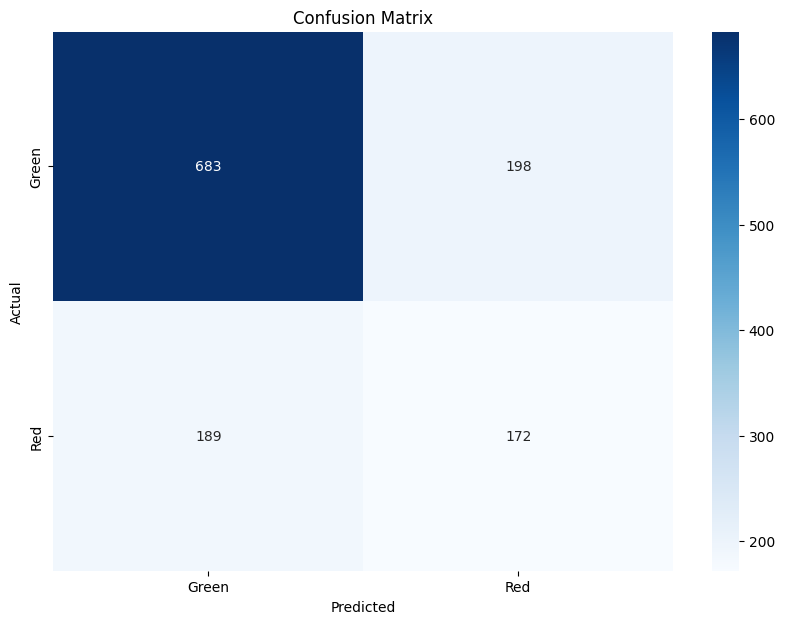


Classification Report:
              precision    recall  f1-score   support

       Green       0.78      0.78      0.78       881
         Red       0.46      0.48      0.47       361

    accuracy                           0.69      1242
   macro avg       0.62      0.63      0.62      1242
weighted avg       0.69      0.69      0.69      1242

Predictions for the additional test set saved as 'My_test_predictions_final.csv'


In [3]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the additional test dataset
test_data_additional = pd.read_csv('My_Test_data.csv')
# test_data_additional = test_data_additional.drop('Mask No', axis=1)

# Define columns
numerical_cols = ['LEASE_TENOR_INCLUDING_HP', 'CUSTOMER AGE', 'Exp', 'YOM']
categorical_cols = ['PRODUCT_NAME', 'Sub_purpose_code_based_on_risk', 'CRIB_SCORE', 'TOTAL INCOME',
                    'Percentage_of_Total_Installments_to_Total_Current_Balance_slabs',
                    'Percentage_of_Total_Current_Balance_to_Total_Amount_Granted_Limit_slabs',
                    'Percentage_of_Total_Arrears_Amount_to_Total_Amount_Granted_Limit_slabs']

# Load the preprocessor
preprocessor = joblib.load('preprocessor_v2.pkl')

# Preprocess the additional test data
X_test_additional_processed = preprocessor.transform(test_data_additional[numerical_cols + categorical_cols])

# Load the best ML model
best_algorithm = joblib.load('best_ml_model_v2.pkl')

# Generate predictions using the ML model
ml_test_predictions_additional = best_algorithm.predict_proba(X_test_additional_processed)

# Concatenate the ML algorithm's predictions with the original input features
X_test_additional_combined = np.hstack([X_test_additional_processed, ml_test_predictions_additional])

# Load the trained ANN model
model = load_model('best_ann_model_v2.h5')

# Generate predictions for the additional test set
y_pred_prob_additional = model.predict(X_test_additional_combined)
y_pred_additional = np.argmax(y_pred_prob_additional, axis=1)

# Load the LabelEncoder to decode the target variable
label_encoder = joblib.load('label_encoder_v2.pkl')

# Inverse transform the encoded predictions to get the original labels
y_pred_additional_labels = label_encoder.inverse_transform(y_pred_additional)

# Save the predictions to a new CSV file
test_data_additional['Predicted_Cluster'] = y_pred_additional_labels
test_data_additional.to_csv('My_test_predictions_final.csv', index=False)

# Generate the confusion matrix
y_true = test_data_additional['Original Cluster']  # Replace 'Original Cluster' with the correct column name
y_pred = test_data_additional['Predicted_Cluster']

conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optionally, print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("Predictions for the additional test set saved as 'My_test_predictions_final.csv'")